Interactive Nodule Workbook

In [1]:
import os
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# global for dimension
EPOCHS = 20
LR = 1e-5
DIM = 2048
MODEL = 'RESUNET-L'
INSTANCENORM = True
HE = True

EXPERIMENT = "JSRT Nodule Segmentation - Image Size=" + str(DIM) + " Network=" + MODEL + " INSTANCE NORM=" + str(INSTANCENORM) + " HE=" + str(HE)

# Load  Dataset

In [2]:
image_path_train = '../data/images'
mask_path_train = '../data/masks'
image_path_test = '../data/test'   #use JPCLN012 for testing

In [3]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [fName.split(".png")[0] for fName in mask]
#image_file_name = [fName.split("_mask")[0] for fName in mask]
image_file_name = [fName.split(".png")[0] for fName in images]

In [4]:
#check = [i for i in mask if "mask" in i]
check = mask
#print("Total mask that has modified name:", len(check))
print("Total JSRT masks:", len(check))

Total JSRT masks: 140


In [5]:
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

In [6]:
len(check)

140

In [7]:
def getData(X_shape, flag = "JSRT"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "MONT":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "SHEN":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
            
    if flag == "JSRT":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i + ".png"), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            if HE:
                #print("applying HE")
                im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
            
            
    # return list
    return im_array, mask_array

In [8]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, shape)
        if HE:
            #print("applying HE")
            im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

# Loading images and masks


In [9]:
dim, n_samples = DIM, 10 # n_samples = [1, 96]

#image_shen, mask_shen = getData(dim, flag = "SHEN")
#image_mont, mask_mont = getData(dim, flag = "MONT")

image_JSRT, mask_JSRT = getData(dim, flag = "JSRT")


X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 10/10 [00:00<00:00, 26.31it/s]


In [10]:
image_JSRT = np.array(image_JSRT).reshape(len(image_JSRT), dim, dim, 1)
mask_JSRT = np.array(mask_JSRT).reshape(len(mask_JSRT), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

print(image_JSRT.shape, mask_JSRT.shape)

print(X_test.shape)

(140, 640, 640, 1) (140, 640, 640, 1)
(10, 640, 640, 1)


In [11]:
assert image_JSRT.shape == mask_JSRT.shape
images = image_JSRT
masks  = mask_JSRT

print(images.shape, masks.shape)

(140, 640, 640, 1) (140, 640, 640, 1)


# Data Augmetation


In [12]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255.0
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

def create_contrast_images_v1(b, c):
    contrast_images = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images.append(apply_brightness_contrast(images[i], brightness=b, contrast=c))
    return contrast_images


In [13]:
#b, c = -40, -120

#contrast_images_v1 = create_contrast_images_v1(b, c)
#contrast_images_v1 = np.array(contrast_images_v1).reshape(len(contrast_images_v1), DIM, DIM, 1)
#print(f'\nshape = {contrast_images_v1.shape}')

In [14]:
def create_contrast_images_v2(alpha, beta):
    contrast_images_v2 = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images_v2.append(cv2.addWeighted(images[i], alpha, images[i], 0, beta))
    return contrast_images_v2

In [15]:
#alpha = 1.5 #@alpha
#beta = 0.7 #@beta

#contrast_images_v2 = create_contrast_images_v2(alpha, beta)
#contrast_images_v2 = np.array(contrast_images_v2).reshape(len(contrast_images_v2), DIM, DIM, 1)
#print(f'\nshape = {contrast_images_v2.shape}')

In [16]:
def noise(i: int = len(images)):
    return np.random.randint(0, 255, size=(i, DIM, DIM, 1))

def noise_images(epsilon: float = 0.1):
    noised = noise()
    noised_img = []
    for i in tqdm(range(len(images)), "noise_images"):
        noised_img.append(noised[i] * epsilon + images[i])
    
    return noised_img

noised_images = noise_images(epsilon=0.1)
noised_images = np.array(noised_images).reshape(len(noised_images), DIM, DIM, 1)
print(f'\nshape = {noised_images.shape}')

noise_images: 100%|██████████| 140/140 [00:00<00:00, 722.71it/s]



shape = (140, 640, 640, 1)


In [17]:
def hflipped_images():
    flipped_img = []
    for i in tqdm(range(len(images)), "hflipped_images"):
        flipped_img.append(np.fliplr(images[i]))
    
    return flipped_img
flipped_images = hflipped_images()
flipped_images = np.array(flipped_images).reshape(len(flipped_images), DIM, DIM, 1)
print(f'\nshape = {flipped_images.shape}')

hflipped_images: 100%|██████████| 140/140 [00:00<00:00, 672626.07it/s]



shape = (140, 640, 640, 1)


In [18]:
def noise_hflipped_images(epsilon: float = 0.1):
    noised = noise()
    noise_flipped_img = []
    for i in tqdm(range(len(images)), "noise_hflipped_images"):
        noise_flipped_img.append(noised[i] * epsilon + np.fliplr(images[i]))
    
    return noise_flipped_img
noise_flipped_images = noise_hflipped_images(epsilon=0.1)
noise_flipped_images = np.array(noise_flipped_images).reshape(len(noise_flipped_images), DIM, DIM, 1)
print(f'\nshape = {noise_flipped_images.shape}')

noise_hflipped_images: 100%|██████████| 140/140 [00:00<00:00, 687.54it/s]



shape = (140, 640, 640, 1)


In [19]:
def hflipped_masks():
    flipped_mask = []
    for i in tqdm(range(len(masks)), "hflipped_masks"):
        flipped_mask.append(np.fliplr(masks[i]))
    
    return flipped_mask
flipped_masks = hflipped_masks()
flipped_masks = np.array(flipped_masks).reshape(len(flipped_masks), DIM, DIM, 1)
print(f'\nshape = {flipped_masks.shape}')

hflipped_masks: 100%|██████████| 140/140 [00:00<00:00, 620721.52it/s]



shape = (140, 640, 640, 1)


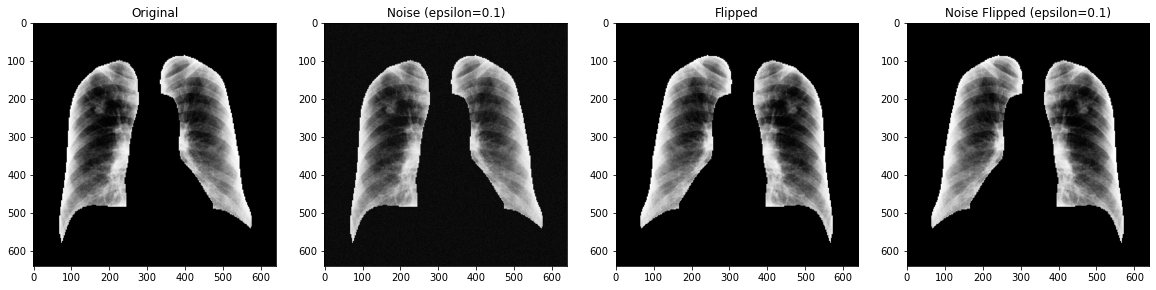

In [20]:
i = 15
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(images[i].reshape(DIM, DIM), cmap='gray')
ax1.set_title('Original')
ax2.imshow(noised_images[i].reshape(DIM, DIM), cmap='gray')
ax2.set_title('Noise (epsilon=0.1)')
ax3.imshow(flipped_images[i].reshape(DIM, DIM), cmap='gray')
ax3.set_title('Flipped')
ax4.imshow(flipped_images[i].reshape(DIM, DIM), cmap='gray')
ax4.set_title('Noise Flipped (epsilon=0.1)')

fig.savefig('./diagrams/' + EXPERIMENT + '_AUGMENTED_IMAGES.png')

#ax4.imshow(masks[i].reshape(DIM, DIM), cmap='gray')
#ax4.set_title('Mask');

In [21]:
#all_images = np.concatenate((images, contrast_images_v1, contrast_images_v2, noised_images), axis=0)
all_images = np.concatenate((images, noised_images, flipped_images, noise_flipped_images), axis=0)
all_masks  = np.concatenate((masks, masks, flipped_masks, flipped_masks), axis=0)

# full res - no need for augmentation in memory
#all_images = images
#all_masks = masks

all_images.shape, all_masks.shape

((560, 640, 640, 1), (560, 640, 640, 1))

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split((all_images - 127.0) / 127.0, 
                                                  (all_masks > 127).astype(np.float32), 
                                                  test_size = 0.2, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

# Model Definition


In [23]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import mlflow
import mlflow.tensorflow

In [24]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [25]:
def bn_act(x, act=True):   
    if INSTANCENORM:
        x = tfa.layers.InstanceNormalization()(x)
    else:
        x = tensorflow.keras.layers.BatchNormalization()(x)    
    if act == True:
        x = tensorflow.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
    c = tensorflow.keras.layers.Concatenate()([u, xskip])
    return c

In [26]:
def ResUNet_S():
    f = [16, 32, 64, 128, 256]
    inputs = tensorflow.keras.layers.Input((dim, dim, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model

def ResUNet_M():
    f = [16, 32, 64, 128, 256, 512]
    inputs = tensorflow.keras.layers.Input((dim, dim, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    e6 = residual_block(e5, f[5], strides=2)

    
    ## Bridge
    b0 = conv_block(e6, f[5], strides=1)
    b1 = conv_block(b0, f[5], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e5)
    d1 = residual_block(u1, f[5])
    
    u2 = upsample_concat_block(d1, e4)
    d2 = residual_block(u2, f[4])
    
    u3 = upsample_concat_block(d2, e3)
    d3 = residual_block(u3, f[3])
    
    u4 = upsample_concat_block(d3, e2)
    d4 = residual_block(u4, f[2])

    u5 = upsample_concat_block(d4, e1)
    d5 = residual_block(u5, f[1])
    
    
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d5)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model

def ResUNet_L(input_size=(256,256,1)):
 
    f = [16, 32, 64, 128, 256, 512, 1024]
    
    inputs = Input((dim, dim, 1))
    
    #inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    e6 = residual_block(e5, f[5], strides=2)
    e7 = residual_block(e6, f[6], strides=2)
    
    ## Bridge
    b0 = conv_block(e7, f[6], strides=1)
    b1 = conv_block(b0, f[6], strides=1)
    
    ## Decoder
    u0 = upsample_concat_block(b1, e6)
    d0 = residual_block(u0, f[6])

    u1 = upsample_concat_block(d0, e5)
    d1 = residual_block(u1, f[5])
    
    u2 = upsample_concat_block(d1, e4)
    d2 = residual_block(u2, f[4])
    
    u3 = upsample_concat_block(d2, e3)
    d3 = residual_block(u3, f[3])
    
    u4 = upsample_concat_block(d3, e2)
    d4 = residual_block(u4, f[2])
    
    u5 = upsample_concat_block(d4, e1)
    d5 = residual_block(u5, f[1])

    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d5)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model


def unet():

    inputs = tensorflow.keras.layers.Input((dim, dim, 1))

    #inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [27]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

2023-02-25 11:21:02.312142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 11:21:02.329270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 11:21:02.329439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 11:21:02.329784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [28]:
mlflow.autolog()
mlflow.set_experiment(EXPERIMENT)

2023/02/25 11:21:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/02/25 11:21:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2023/02/25 11:21:06 INFO mlflow.tracking.fluent: Experiment with name 'JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE NORM=True HE=True' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///data/mjhorry/Experiments/Nodule_Segmentation_Interactive/main/mlruns/18', creation_time=1677284466515, experiment_id='18', last_update_time=1677284466515, lifecycle_stage='active', name=('JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE '
 'NORM=True HE=True'), tags={}>

In [29]:
if MODEL == 'RESUNET-M':
    print("USING RESUNET-M")
    model = ResUNet_M()
    modelA = ResUNet_M()
    modelB = ResUNet_M()
    modelC = ResUNet_M()
elif MODEL == 'RESUNET-S':
    print("USING RESUNET-S")
    model = ResUNet_S()
    modelA = ResUNet_S()
    modelB = ResUNet_S()
    modelC = ResUNet_S()
elif MODEL == 'RESUNET-L':
    print("USING RESUNET-L")
    model = ResUNet_L()
    modelA = ResUNet_L()
    modelB = ResUNet_L()
    modelC = ResUNet_L()
else:
    model = unet()
    modelA = unet()
    modelB = unet()
    modelC = unet()
    
adam = tensorflow.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=adam, loss=loss, metrics=metrics)
#model.summary()    

USING RESUNET-L


In [30]:
#from keras.utils.vis_utils import plot_model
#tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
weight_path="./models/{}-{}.h5".format(EXPERIMENT, 'epoch-{epoch:04d}')
weight_path_best="./models/{}.h5".format('BEST-NODULESEG-' + EXPERIMENT)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

checkpointALL = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=False, mode='auto', save_freq='epoch')
checkpointBEST = ModelCheckpoint(weight_path_best, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')


callbacks_list = [checkpointALL, checkpointBEST, reduceLROnPlat]

In [32]:
#initialize random seeds so results are repeatable
import random
import tensorflow as tf

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [33]:
# batch size was 32
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=8, epochs=EPOCHS,
                callbacks=callbacks_list)

2023/02/25 11:21:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '429b174c4f5140b1bfed9a5f066674e7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/20


2023-02-25 11:21:17.746393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


56/56 [==============================] - ETA: 0s - loss: 0.9931 - dice_coef: 0.0069 - jaccard_coef: 0.0035 - binary_accuracy: 0.6384 - precision: 0.0039 - recall: 0.9509
Epoch 00001: saving model to ./models/JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE NORM=True HE=True-epoch-0001.h5

Epoch 00001: val_loss improved from inf to 0.99192, saving model to ./models/BEST-NODULESEG-JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE NORM=True HE=True.h5
56/56 [==============================] - 67s 963ms/step - loss: 0.9931 - dice_coef: 0.0069 - jaccard_coef: 0.0035 - binary_accuracy: 0.6384 - precision: 0.0039 - recall: 0.9509 - val_loss: 0.9919 - val_dice_coef: 0.0081 - val_jaccard_coef: 0.0041 - val_binary_accuracy: 0.7095 - val_precision: 0.0045 - val_recall: 0.9969 - lr: 1.0000e-05
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 0.9888 - dice_coef: 0.0112 - jaccard_coef: 0.0056 - binary_accuracy: 0.7715 - precision: 0.0063 - rec

2023-02-25 11:39:23.974947: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp5j4te51_/model/data/model/assets


2023/02/25 11:39:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5j4te51_/model, flavor: keras), fall back to return ['tensorflow==2.7.0', 'keras==2.7.0']. Set logging level to DEBUG to see the full traceback.


# plot model response

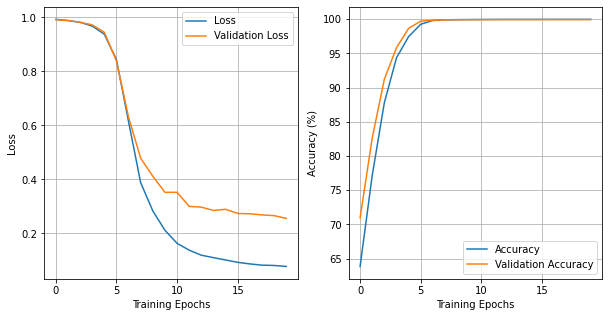

In [34]:
# loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.grid(True)
ax2.grid(True)

ax1.set_xlabel('Training Epochs')
ax1.set_ylabel('Loss')

ax2.set_xlabel('Training Epochs')
ax2.set_ylabel('Accuracy (%)')

ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()
ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

fig.savefig('./diagrams/' + EXPERIMENT + '_ACCURACY_LOSS.png')

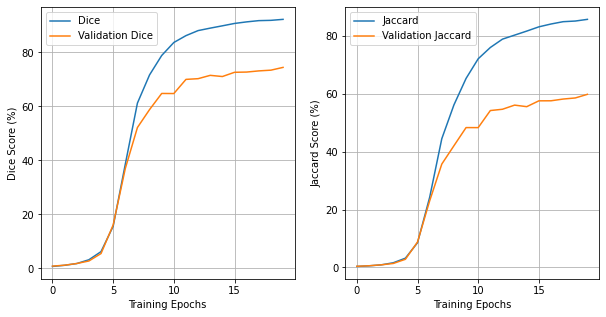

In [35]:
# dice and jaccard
fig, (ax3, ax4) = plt.subplots(1, 2, figsize = (10, 5))

ax3.grid(True)
ax4.grid(True)

ax3.set_xlabel('Training Epochs')
ax3.set_ylabel('Dice Score (%)')

ax4.set_xlabel('Training Epochs')
ax4.set_ylabel('Jaccard Score (%)')


ax3.plot(100 * np.array(res.history['dice_coef']), '-', 
         label = 'Dice')
ax3.plot(100 * np.array(res.history['val_dice_coef']), '-',
         label = 'Validation Dice')
ax3.legend();
ax4.plot(100 * np.array(res.history['jaccard_coef']), '-', 
         label = 'Jaccard')
ax4.plot(100 * np.array(res.history['val_jaccard_coef']), '-',
         label = 'Validation Jaccard')
ax4.legend();

fig.savefig('./diagrams/' + EXPERIMENT + '_DICE_JACCARD.png')

# Prediction on Validation set

In [36]:
# search the saved models for highest Dice score
# optimisation
from keras.models import load_model

WINDOW = 3

lst = [*range(1, EPOCHS,1)]

combos = []

alldice = []
bestcombo = ''
modelfileA_best = ''
modelfileB_best = ''
modelfileC_best = ''


def sliding_window(elements, window_size):
    
    if len(elements) <= window_size:
       return elements
    for i in range(len(elements)- window_size + 1):
        combos.append(elements[i:i+window_size])
        
sliding_window(lst, 3)

for i in combos:
    
    iterdicelist = []
    
    modelfileA = './models/' + EXPERIMENT + '-epoch-{:04d}.h5'.format(i[0])
    modelfileB = './models/' + EXPERIMENT + '-epoch-{:04d}.h5'.format(i[1])
    modelfileC = './models/' + EXPERIMENT + '-epoch-{:04d}.h5'.format(i[2])
    
    model_list = []

    #modelA = ResUNet_M()
    modelA.load_weights(modelfileA)
    model_list.append(modelA)

    #modelB = ResUNet_M()
    modelB.load_weights(modelfileB)
    model_list.append(modelB)

    #modelC = ResUNet_M()
    modelC.load_weights(modelfileC)
    model_list.append(modelC)


    model_input = tf.keras.Input(shape=(DIM, DIM, 1))
    model_outputs = [model(model_input) for model in model_list]

    ensemble_output = tf.keras.layers.Maximum()(model_outputs)

    model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    
    preds_val = model.predict(X_val, batch_size=1)
    
    for j in range(10):
        score = dice_coef(preds_val[j], Y_val[j]).numpy() * 100
        iterdicelist.append(score)
        
            
    # calculate the average DICE
    averagedice = sum(iterdicelist) / len(iterdicelist)
    alldice.append(averagedice)
    if averagedice >= max(alldice):
        bestcombo = "Best Combo {}:{}:{}".format(i[0],i[1],i[2])
        modelfileA_best = modelfileA
        modelfileB_best = modelfileB
        modelfileC_best = modelfileC

        
    #print("Combo {}:{}:{} - Average dice is: {:.2f}".format(i[0],i[1],i[2],averagedice))  
print(bestcombo)
print(modelfileA_best)
print(modelfileB_best)
print(modelfileC_best)

Best Combo 16:17:18
./models/JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE NORM=True HE=True-epoch-0016.h5
./models/JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE NORM=True HE=True-epoch-0017.h5
./models/JSRT Nodule Segmentation - Image Size=640 Network=RESUNET-L INSTANCE NORM=True HE=True-epoch-0018.h5


In [37]:
model_list = []

#modelA = ResUNet_M()
modelA.load_weights(modelfileA_best)
model_list.append(modelA)

#modelB = ResUNet_M()
modelB.load_weights(modelfileB_best)
model_list.append(modelB)

#modelC = ResUNet_M()
modelC.load_weights(modelfileC_best)
model_list.append(modelC)


model_input = tf.keras.Input(shape=(DIM, DIM, 1))
model_outputs = [model(model_input) for model in model_list]
        
ensemble_output = tf.keras.layers.Maximum()(model_outputs)

model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [38]:
preds_val = model.predict(X_val, batch_size=1)

average dice is: 63.10


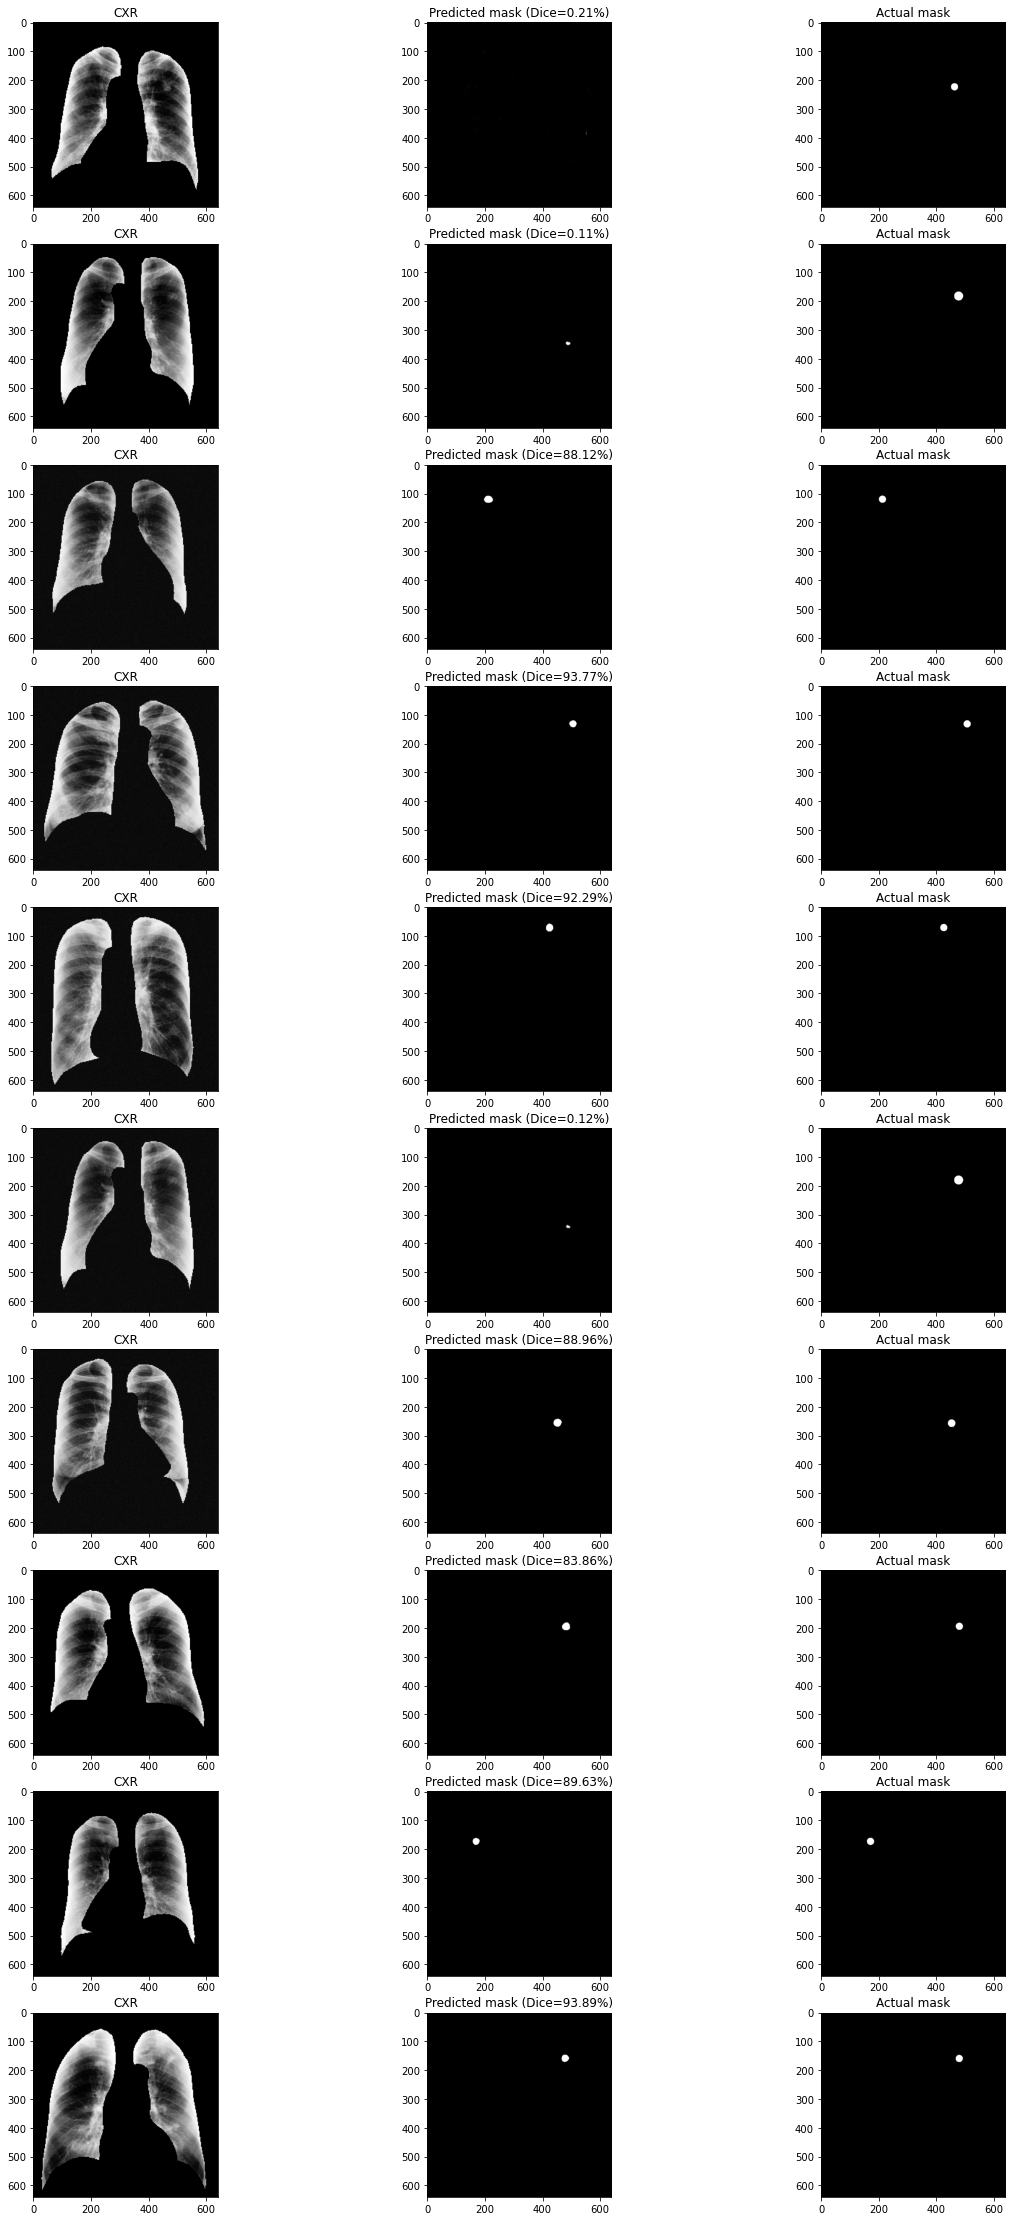

In [39]:
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(20, 40))

dicelist = []

for i in range(10):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_val[i].reshape(DIM, DIM), cmap='gray')
            axs[i, j].set_title('CXR')
        elif j == 1:
            axs[i, j].imshow(preds_val[i].reshape(DIM, DIM), cmap='gray')
            score = dice_coef(preds_val[i], Y_val[i]).numpy() * 100
            dicelist.append(score)
            axs[i, j].set_title('Predicted mask (Dice={:.2f}%)'.format(score))
       
        elif j == 2:
            axs[i, j].imshow(Y_val[i].reshape(DIM, DIM), cmap='gray')
            axs[i, j].set_title('Actual mask')
                       
# calculate the average DICE
averagedice = sum(dicelist) / len(dicelist)

fig.savefig('./diagrams/' + EXPERIMENT + '_PREDICTIONS_DICE=' + str(averagedice) + '.png')

print("average dice is: {:.2f}".format(averagedice))


In [40]:
preds = model.predict(X_testNorm, batch_size=1)

IndexError: index 10 is out of bounds for axis 0 with size 10

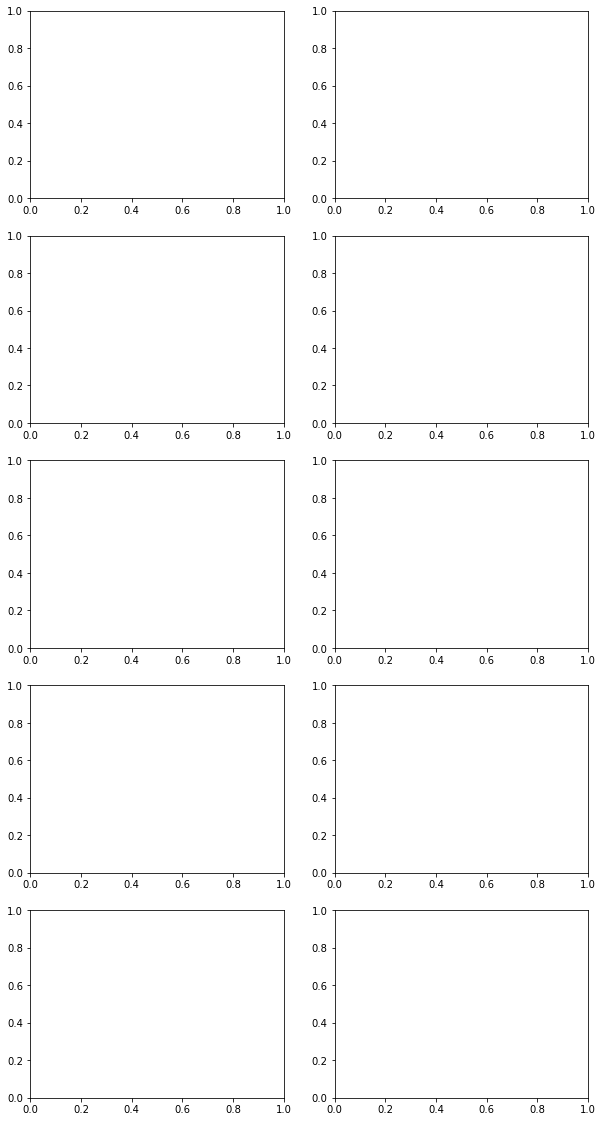

In [41]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('predicted mask')

In [ ]:
# Optimiation Part